In [1]:
import sys
sys.path

['D:\\bio\\jupyter_code\\seqFish-SpatialMouseAtlas',
 'D:\\anaconda\\envs\\SPACEL\\python38.zip',
 'D:\\anaconda\\envs\\SPACEL\\DLLs',
 'D:\\anaconda\\envs\\SPACEL\\lib',
 'D:\\anaconda\\envs\\SPACEL',
 '',
 'C:\\Users\\23147\\AppData\\Roaming\\Python\\Python38\\site-packages',
 'D:\\anaconda\\envs\\SPACEL\\lib\\site-packages',
 'D:\\anaconda\\envs\\SPACEL\\lib\\site-packages\\win32',
 'D:\\anaconda\\envs\\SPACEL\\lib\\site-packages\\win32\\lib',
 'D:\\anaconda\\envs\\SPACEL\\lib\\site-packages\\Pythonwin']

In [2]:
import os
import matplotlib.pyplot as plt 

print(os.getcwd())#显示当前路径
os.chdir('D:/bio/SPACEL/SPACEL-main')#更改路径，''里面为更改的路径
print(os.getcwd())#显示当前路径

D:\bio\jupyter_code\seqFish-SpatialMouseAtlas
D:\bio\SPACEL\SPACEL-main


In [3]:
# datasets = ["embryo1-2","embryo1-5","embryo2-2","embryo2-5","embryo3-2","embryo3-5"]
datasets = ["embryo1-5","embryo2-5","embryo3-5"]
experiment_name = 'z5'
input_dir = 'G:/dataset/07-seqFish-SpatialMouseAtlas/output/python/'  # Replace it with your file path
output_dir = 'G:/dataset/07-seqFish-SpatialMouseAtlas/output/SPACEL/'  # Replace it with your file path

In [ ]:
import SPACEL.Splane.utils
import pandas as pd
import scanpy as sc
import anndata as ad

for dataset in datasets:
    # adata = sc.read_visium(input_dir + dataset)
    # adata.var_names_make_unique()
    # adata.obs_names_make_unique()
    
    matrix = pd.read_csv(input_dir + dataset + "/matrix.csv", index_col=False)
    feature = pd.read_csv(input_dir + dataset + "/features.csv", index_col=0)
    feature.index.name = 'gene'
    barcode = pd.read_csv(input_dir + dataset + "/barcodes.csv", index_col=0)
    barcode.index.name = 'spot'
    adata = ad.AnnData(X=matrix.to_numpy(dtype='float64').T, obs=barcode, var=feature)
    
    positions = pd.read_csv(input_dir + dataset + "/tissue_positions_list.csv", index_col=0, header=None)
    positions.drop(positions.columns[[0, 3, 4]], axis=1, inplace=True)
    positions.columns = ['x', 'y']
    adata.obsm['spatial'] = positions.values
    
    adata_label = pd.read_csv(input_dir + dataset + '/truth.csv', index_col=0)
    # adata_label.index = [str.replace(str.replace(x, '.', '-'), adata_label['batch'][0] + '-', '') for x in adata_label.index]
    adata.obs['batch'] = adata_label['batch']
    adata.obs['annotation'] = adata_label['celltype_mapped_refined']
#     adata_list.append(adata)
    
    adata_label.rename(columns={'celltype_mapped_refined': 'spatial_domain'}, inplace=True)
    SPACEL.Splane.utils.add_cell_type_composition(adata, adata_label)
    adata.uns['celltypes'] = adata.uns['celltypes'].tolist()
    
    print(adata.isbacked)
    adata.filename = output_dir + 'SPACEL_' + dataset + '.h5ad'
    print(adata.isbacked)

# for dataset in datasets:
#     adata = sc.read_visium(input_dir + dataset)
#     adata.var_names_make_unique()
#     adata.obs_names_make_unique()
#     adata_label = pd.read_csv(input_dir + dataset + '/' + dataset + '_truth.csv')
#     adata_label = adata_label[['batch', 'ground.truth']]
#     adata_label.rename(columns={'ground.truth': 'spatial_domain'}, inplace=True)
#     SPACEL.Splane.utils.add_cell_type_composition(adata, adata_label)
#     adata.uns['celltypes'] = adata.uns['celltypes'].tolist()
#     print(adata.isbacked)
#     adata.filename = output_dir + 'SPACEL_' + dataset + '.h5ad'
#     print(adata.isbacked)


# adata = sc.read_h5ad('D:/dataset/151508/SPACEL_151508.h5ad')
# print(adata)
# print(adata.obs)


In [4]:
import scanpy as sc
import pandas as pd
adata_list = []
for dataset in datasets:
    path = output_dir + 'SPACEL_' + dataset + '.h5ad'
    print(path)
    adata_list.append(sc.read_h5ad(path))


G:/dataset/07-seqFish-SpatialMouseAtlas/output/SPACEL/SPACEL_embryo1-5.h5ad
G:/dataset/07-seqFish-SpatialMouseAtlas/output/SPACEL/SPACEL_embryo2-5.h5ad
G:/dataset/07-seqFish-SpatialMouseAtlas/output/SPACEL/SPACEL_embryo3-5.h5ad


## Pairwise alignment
Here, we perform pairwise alignment of slices. The cluster_key is a column of .obs which contain spatial domain information used for alignment. The n_neighbors affect how much neighbors are considered when calculate similarity of two slices. The knn_exclude_cutoff affect max distance of neighbors. By default, knn_exclude_cutoff = n_neighbors, which means a spot/cell in source slices consider knn_exclude_cutoff neighbors in target slices, and neighbor will be exclude when the distance of neighbors larger than the median of neareast knn_exclude_cutoff + n_neighbors neighbors distance in all spot/cell in target slice. p affect the exponent of overlap penalty, and a larger p means stronger partial alignment capability.

In [5]:
from SPACEL import Scube
Scube.align(adata_list,
  cluster_key='spatial_domain', 
  n_neighbors = 4, 
  p=1,
  write_loc_path = output_dir + experiment_name + '_aligned_coordinates.csv'
 )

# sc.concat(adata_list).write('../data/ST_mouse_brain/mouse_brain_st.h5ad')

Start alignment...
Alignment slice 1 to 0
Alignment slice 2 to 1
Runtime: 1427.4255013465881 s


In [6]:
adata_list[0]
adata_list[1]

AnnData object with n_obs × n_vars = 6880 × 351
    obs: 'batch', 'annotation', 'spatial_domain'
    uns: 'celltypes'
    obsm: 'spatial', 'spatial_pair', 'spatial_aligned'

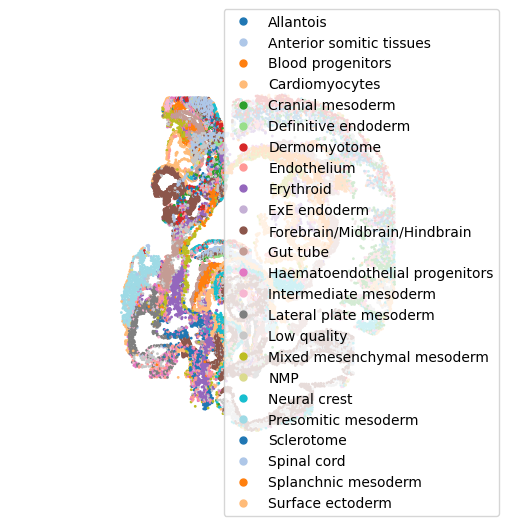

In [7]:
Scube.plot_stacked_slices(adata_list,spatial_key='spatial',cluster_key='spatial_domain')
plt.savefig(output_dir + experiment_name + "_spatial.png", dpi=300)

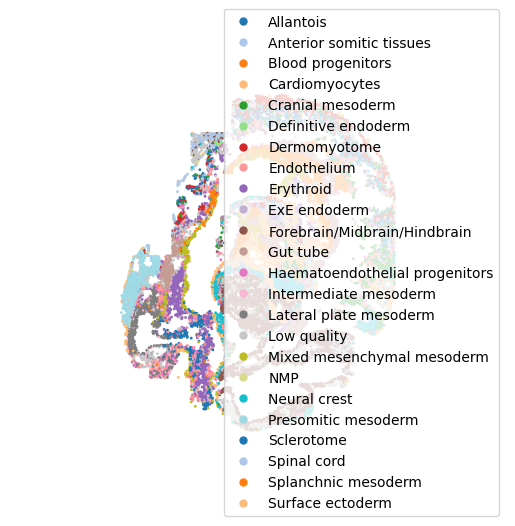

In [8]:
Scube.plot_stacked_slices(adata_list,spatial_key='spatial_pair',cluster_key='spatial_domain')
plt.savefig(output_dir + experiment_name + "_spatial_pair.png", dpi=300)

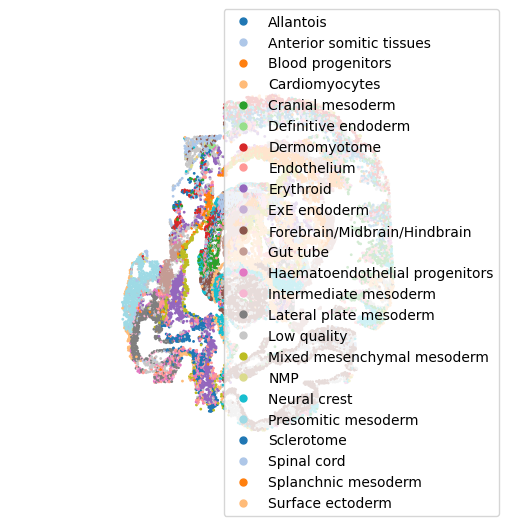

In [9]:
Scube.plot_stacked_slices(adata_list,spatial_key='spatial_aligned',cluster_key='spatial_domain')
plt.savefig(output_dir + experiment_name + "_spatial_aligned.png", dpi=300)

In [10]:
# import seaborn as sns
# slice_colors = sns.color_palette(n_colors = 6).as_hex()
df = pd.DataFrame()
for i in range(len(adata_list)):
    df = pd.concat([df,adata_list[i].obs],axis=0)

series = df.iloc[:, 1]
series = series.astype("category")

celltype_num = len(series.value_counts().index)
celltypes = series.value_counts().index.tolist()

import seaborn as sns
colors = sns.color_palette(n_colors = celltype_num).as_hex()

D:\bio\SPACEL\SPACEL-main\SPACEL\Scube\plot.py:63: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(loc[:,0], loc[:,1], loc[:,2],c=color,*args,**kwargs)


G:/dataset/07-seqFish-SpatialMouseAtlas/output/SPACEL/z5_spatial_aligned_3d.png


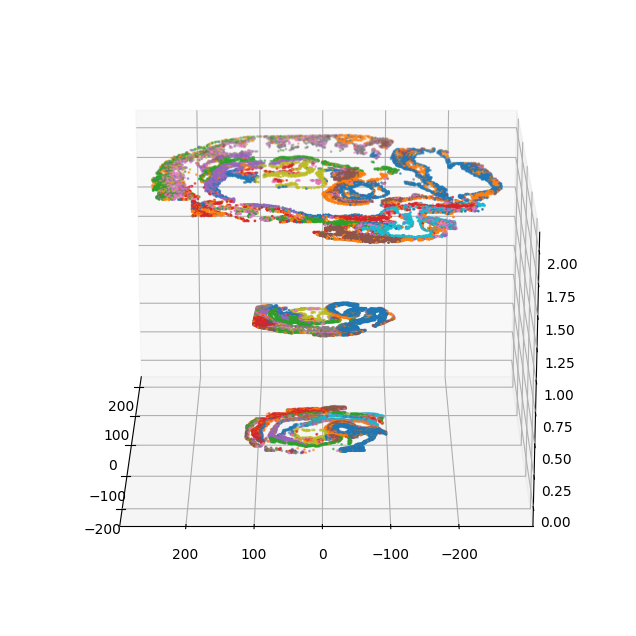

In [11]:
coo = pd.DataFrame()
for i in range(len(adata_list)):
    loc = adata_list[i].obsm['spatial_aligned'].copy()
    loc['Z'] = i
    loc['celltype_colors'] = adata_list[i].obs['spatial_domain'].replace(dict(zip(celltypes, colors)))
    coo = pd.concat([coo,loc],axis=0)
path = output_dir + experiment_name + "_spatial_aligned_3d.png"
Scube.plot_3d(coo.values[:,:3],val=None,color=coo['celltype_colors'],show=True,elev=20,azim=180,s=1,save_path=path, save_dpi=300)

In [12]:
for i in range(len(adata_list)):
    adata = adata_list[i]
    dataset = datasets[i]
    print(adata.isbacked)
    adata.filename = output_dir + 'SPACEL_aligned_' + experiment_name + '_' + dataset + '.h5ad'
    print(adata.isbacked)

False
True
False
True
False
True
